In [2]:
import numpy as np # Import numpy
import ROOT # Import ROOT
import pythia8 # Import pythia8
import os # Import os 
import time # Import time


cling::DynamicLibraryManager::loadLibrary(): libGL.so.1: cannot open shared object file: No such file or directory
Error in <AutoloadLibraryMU>: Failed to load library /home/johnm100/miniconda3/envs/myenv/lib/libEve.so.6.28.04cling JIT session error: Failed to materialize symbols: { (main, { _ZeqRK7TStringRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE }) }


Welcome to JupyROOT 6.28/04


In [2]:
class pythiaObj:
    ''' A class to hold the pythia object and its settings '''
    
    def __init__(self, beamEnergy, beamA, beamB, nevents = 1000):
        ''' Initialize the pythia object'''
        self.settings = []
        inputparams = ['Beams:eCM', 'Beams:idA', 'Beams:idB', 'Main:numberOfEvents']
        inputs = [beamEnergy, beamA, beamB, nevents]
        for i in range(len(inputparams)):
            self.settings.append(f'{inputparams[i]} = {inputs[i]}')
        self.settings.append("HardQCD:all = on")
        self.Seed() # Set the seed
        
    def Seed(self):
        ''' 
        Set the seed for the pythia object based on the time.
        '''
        # random seed based on time
        seed = (time.time()*100000)%900000 
        seed = int(seed)
        print("Seed: {}".format(seed))
        # seed needs to be between 0 and 900000000
        if seed < 0:
            seed *= -1
        seedstrs = ["Random:setSeed = on", "Random:seed = {}".format(seed)]
        # remove all seed options
        self.settings = [x for x in self.settings if not 'Random' in x]
        for seedstr in seedstrs:
            self.settings.append(seedstr)
       
    def GetSettings(self):
        ''' Get the current settings of the pythia object '''
        return self.settings
        
    def WriteSettings(self, filename):
        ''' Write the current settings to a file '''
        with open(filename, 'w') as f:
            for key in self.settings:
                f.write(key + '\n')
        
    def DefaultSettings(self):
        ''' Reset the settings to default '''
        setstrs = []
        setstrs.append("Beams:eCM = 5020")
        setstrs.append("Beams:idA = 2212")
        setstrs.append("Beams:idB = 2212")
        setstrs.append("Main:numberOfEvents = 10000")
        setstrs.append("HardQCD:all = on")
        self.settings = setstrs
        self.Seed()
    
    def ResetSettings(self, beamEnergy, beamA, beamB, nevents = 1000):
        ''' Reset the settings '''
        self.settings = []
        inputparams = ['Beams:eCM', 'Beams:idA', 'Beams:idB', 'Main:numberOfEvents']
        inputs = [beamEnergy, beamA, beamB, nevents]
        for i in range(len(inputparams)):
            self.settings.append(f'{inputparams[i]} = {inputs[i]}')
        self.settings.append("HardQCD:all = on")
        self.Seed()
        
    def pTHard(self, min, max =-1):
        ''' Set the pTHard min and max '''
        # remove all pTHard options
        self.settings = [x for x in self.settings if not 'pTHard' in x]
        if max == -1:
            self.settings.append("PhaseSpace:pTHatMin = {}".format(min))
        else:
            self.settings.append("PhaseSpace:pTHatMin = {}".format(min))
            self.settings.append("PhaseSpace:pTHatMax = {}".format(max))
                
    def HardQCD(self, option=True):
        ''' Set the HardQCD option'''
        # remove all HardQCD options
        self.settings = [x for x in self.settings if not 'HardQCD' in x]
        if option:
            self.settings.append("HardQCD:all = on")
        else:
            self.settings.append("HardQCD:all = off")
      
    def PDF(self, pdf, extrapolate = True):
        ''' Set the PDF '''
        # remove all PDF options
        self.settings = [x for x in self.settings if not 'PDF' in x]
        self.settings.append("PDF:pSet = {}".format(pdf))
        if extrapolate:
            self.settings.append("PDF:extrapolate = on")
        else:
            self.settings.append("PDF:extrapolate = off")
    
    def ResetPDF(self):
        ''' Reset the PDF to default '''
        self.settings = [x for x in self.settings if not 'PDF' in x]
        self.settings.append("PDF:pSet = 13")
        self.settings.append("PDF:extrapolate = off")
             
    def Fragmentation(self, Lstring, value):
        ''' Set the fragmentation '''
        if Lstring != 'aLund' and Lstring != 'bLund':
            print("Error: Lstring must be 'aLund' or 'bLund'")
            return
        # remove all fragmentation options
        self.settings = [x for x in self.settings if not Lstring in x]
        self.settings.append("StringZ:{} = {}".format(Lstring, value))
        
    def ResetFragmentation(self):
        ''' Reset the fragmentation to default '''
        self.settings = [x for x in self.settings if not 'StringZ' in x]
        self.settings.append("StringZ:aLund = 0.68")
        self.settings.append("StringZ:bLund = 0.98")
        
    def Tune(self, tune):
        ''' Set the tune '''
        # remove all tune options
        self.settings = [x for x in self.settings if not 'Tune' in x]
        self.settings.append("Tune:pp = {}".format(tune))
    
    def Init(self):
        ''' Initialize the pythia object '''
        self.pythia = pythia8.Pythia()
        for key in self.settings:
            self.pythia.readString(key)
        # Initialize the pythia object with minimal output
        self.pythia.readString("Next:numberShowEvent = 0")
        self.pythia.readString("Next:numberShowProcess = 0")
        self.pythia.readString("Next:numberShowInfo = 0")
        self.pythia.readString("Next:numberShowLHA = 0")
        self.pythia.readString("Init:showChangedSettings = off")
        self.pythia.readString("Init:showAllSettings = off")
        self.pythia.readString("Init:showProcesses = off")
        self.pythia.init()
              
    def Next(self):
        ''' Generate the next event '''
        if not self.pythia.next():
            print("Error: event generation failed!")
            return
        event = self.pythia.event
        return event

In [3]:
#def writeobject(nevents) #Turn everything in this cell into this function (except for initialization)



def writeobject(nevents,filename,pythia_object): 
    #Receives nevents and pythia initialization to create particle characteristics tree
    event_multiplicity = np.zeros(1, dtype=int) # Create a new branch for the event multiplicity
    particle_px = np.zeros(10000, dtype=float) # Create a new branch for the particle px
    particle_py = np.zeros(10000, dtype=float) # Create a new branch for the particle py
    particle_pz = np.zeros(10000, dtype=float) # Create a new branch for the particle pz
    particle_E = np.zeros(10000, dtype=float) # Create a new branch for the particle E
    particle_pT = np.zeros(10000, dtype=float) #New
    particle_phi = np.zeros(10000, dtype=float) #New
    particle_eta = np.zeros(10000, dtype=float) #New
    particle_charge = np.zeros(10000, dtype=float) #New
    particle_pid = np.zeros(10000, dtype=int) # Create a new branch for the particle pid



    f = ROOT.TFile(filename, 'recreate') #Initializing Tfile 
    tree = ROOT.TTree('tree', 'tree')

    tree.Branch('event_multiplicity', event_multiplicity, 'event_multiplicity/I') # Add the event multiplicity branch to the tree
    tree.Branch('particle_px', particle_px, 'particle_px[event_multiplicity]/D') # Add the particle px branch to the tree
    tree.Branch('particle_py', particle_py, 'particle_py[event_multiplicity]/D') # Add the particle py branch to the tree
    tree.Branch('particle_pz', particle_pz, 'particle_pz[event_multiplicity]/D') # Add the particle pz branch to the tree
    tree.Branch('particle_E', particle_E, 'particle_E[event_multiplicity]/D') # Add the particle E branch to the tree
    tree.Branch('particle_pT', particle_pT, 'particle_pT[event_multiplicity]/D') #New
    tree.Branch('particle_phi', particle_phi, 'particle_phi[event_multiplicity]/D') #New
    tree.Branch('particle_eta', particle_eta, 'particle_eta[event_multiplicity]/D') #New
    tree.Branch('particle_charge', particle_charge, 'particle_charge[event_multiplicity]/D') #New
    tree.Branch('particle_pid', particle_pid, 'particle_pid[event_multiplicity]/I') # Add the particle pid branch to the tree
     
    for i in range(nevents): # Loop over the events
        event = pythia_object.Next() # Generate the next event
        event_multiplicity[0] = 0
   
    
        for j in range(event.size()):
            if not event[j].isFinal(): # Skip if the particle is not final
                continue
            particle = event[j] # Get the particle
            if particle.phi() == 0 and particle.eta() == 0:
                continue 
            event_multiplicity[0] += 1 # Increment the event multiplicity
        
        
            particle_px[j] = particle.px() # Set the particle px
            particle_py[j] = particle.py() # Set the particle py
            particle_pz[j] = particle.pz() # Set the particle pz
            particle_E[j] = particle.e() # Set the particle E
            particle_pT[j] = particle.pT() #New
            particle_phi[j] = particle.phi() #New
            particle_eta[j] = particle.eta() #New
            particle_charge[j] = particle.charge() #New
            particle_pid[j] = particle.id() # Set the particle pid

        #Accumulation of lists to collect characteristics when Phi is 0
        
    
        #Loops to iterate through particles on the condition that either phi or eta are 0
        






        # Fill the tree
        tree.Fill() # Fill the tree
        # Print the event number every 100 events
        if i%100 == 0:
            print("Event: {}".format(i))
    
    # Write the tree to the ROOT file
    f.Write() # Write the ROOT file
    f.Close() # Close the ROOT file
    

In [4]:
#def writeobject(nevents) #Turn everything in this cell into this function (except for initialization)


settings_filename = 'settings.txt' # Set the filename to testdir/testfile.txt
pyt = pythiaObj(beamEnergy = 5020, beamA = 2212, beamB = 2212) # Initialize the pythia object for 5.02 TeV p+p collisions
pyt.pTHard(20) # Set the pTHard min to 20 GeV
pyt.PDF(4) # Set the PDF
pyt.WriteSettings(settings_filename) # Write the settings to a file
pyt.Init() # Initialize the pythia object

writeobject(500, 'john.root',pyt)

     
    

Seed: 115903
Event: 0
Event: 100
Event: 200
Event: 300
Event: 400

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 16 Oct 2023 at 15:13:13    |  | 
 |  |                                      

In [5]:
settings_filename = 'experiment.txt' # Set the filename to testdir/testfile.txt
pyt = pythiaObj(beamEnergy = 5020, beamA = 2212, beamB = 2212) # Initialize the pythia object for 5.02 TeV p+p collisions
pyt.pTHard(50) # Set the pTHard min to 20 GeV
pyt.PDF(8) # Set the PDF
pyt.Tune(14)
pyt.WriteSettings(settings_filename) # Write the settings to a file
pyt.Init() # Initialize the pythia object

writeobject(500, 'experiment.root',pyt)



Seed: 578861
Event: 0
Event: 100
Event: 200
Event: 300
Event: 400

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 16 Oct 2023 at 15:19:17    |  | 
 |  |                                      

In [1]:
#My attempt:

import uproot
import matplotlib.pyplot as plt

root_file_path = "john.root"
tree_name = "tree"
branch_name = ["particle_px"]

def plot_root_tree(root_file_path, tree_name, branch_name):
    # Open the ROOT file and access the specified tree
    file = uproot.open(root_file_path)
    tree = file[tree_name]

    # Read the branch data into a NumPy array
    data = tree.arrays(branch_name)

    # Create a histogram or plot
    plt.figure()
    
    
    plt.hist(data[0])
    

    # Show the plot
    plt.show()




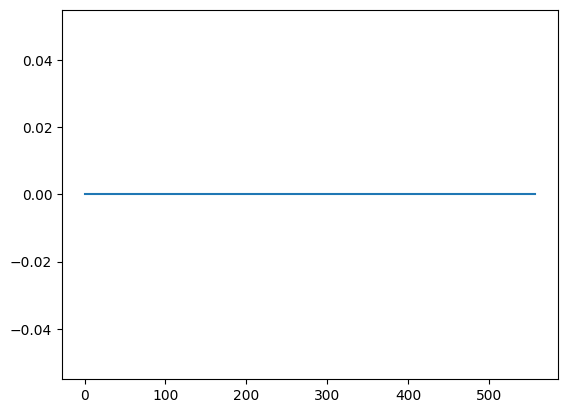

In [75]:
from matplotlib import pyplot as plt
import uproot
import pandas as pd



root_file_path = "/home/johnm100/researchproject/Undergrad-Research/tutorials/john.root"
tree_name = "tree"
branch_name = ["event_multiplicity", "particle_px", "particle_py", "particle_py", "particle_pz", "particle_E", "particle_pT", "particle_phi", "particle_eta", "particle_charge", "particle_pid"]
output_dir = "tutorials/researchprojects.ipynb"



def GetData(filename, treename='tree'):

    '''
    Returns TFile as a pandas dataframe
    '''
    
    file = uproot.open(filename)
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    file.close()
    return df

#data = root_file.tree2array(tree, branches=branch_name)
data = GetData(root_file_path)
fig = plt.figure()
plt.plot(data['particle_charge'][0])
plt.show()




In [4]:
import matplotlib as plt
def readfile(root_file_path, tree_name, branch_name, output_dir)            #Create function to read the .root file. Make this function create some charts based on particle characteristics. 
    
    root_file = ROOT.TFile(root_file_path, "READ")
    tree = root_file.Get(tree_name)

    data = root_file.tree2array(tree, branches=branch_name)

    # Create plots for each branch
    #for i in branch_name:

        #plt.figure(figsize=(8, 6))
        #plt.hist(data[branch_name], bins=(), alpha=0.7, color='b')
        #plt.title(f'{branch_name} Distribution')
        #plt.xlabel(branch_name)
        #plt.ylabel('value')
        #plt.grid(True)
        #plt.savefig(f'{output_dir}/{branch_name}_plot.png')
        #plt.show()
        


root_file_path = "john.root"
tree_name = "tree"
branch_name = ["event_multiplicity", "particle_px", "particle_py", "particle_py", "particle_pz", "particle_E", "particle_pT", "particle_phi", "particle_eta", "particle_charge", "particle_pid"]
output_dir = "tutorials/researchprojects.ipynb"

    
        



        
        

SyntaxError: invalid syntax (367351807.py, line 2)

In [ ]:
#Current Assignment (oct 23 meeting): Find way to find correct values in read function. Read it into pandas dataframe